In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from models.unets.unets import DenoisingUNet
from models.autoencoder import DilatedConvAutoencoder
from models.unets.unets import BatchRenormalizationUNet
from config import DEVICE
from utils.utils import psnr


def add_speckle_noise(image, speckle_mean_add=0.0, speckle_std_add=0.1,
                      speckle_mean_mul=0.0, speckle_std_mul=0.1,
                      mult_noise_magnitude=1.0, addi_noise_magnitude=1.0):
    """
    Add speckle noise to an image.

    Args:
        image (torch.Tensor): Input image data in grayscale (shape: [C, H, W]).
        speckle_mean_add (float): Mean of the additive Gaussian noise.
        speckle_std_add (float): Standard deviation of the additive Gaussian noise.
        speckle_mean_mul (float): Mean of the multiplicative Gaussian noise.
        speckle_std_mul (float): Standard deviation of the multiplicative Gaussian noise.
        mult_noise_magnitude (float): Magnitude of the multiplicative noise.
        addi_noise_magnitude (float): Magnitude of the additive noise.

    Returns:
        torch.Tensor: Noisy image data.
    """
    _, row, col = image.shape
    
    # Generate additive Gaussian noise
    additive_gauss = torch.normal(speckle_mean_add, speckle_std_add, (row, col))
    
    # Generate multiplicative Gaussian noise
    multiplicative_gauss = torch.normal(speckle_mean_mul, speckle_std_mul, (row, col))
    
    # Apply speckle noise
    noisy = image + mult_noise_magnitude * image * multiplicative_gauss + addi_noise_magnitude * additive_gauss
    
    return noisy

/tmp/ipykernel_25171/2034727905.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict[model_name].load_state_dict(torch.load(f"{model_name}_trained_model.pth", map

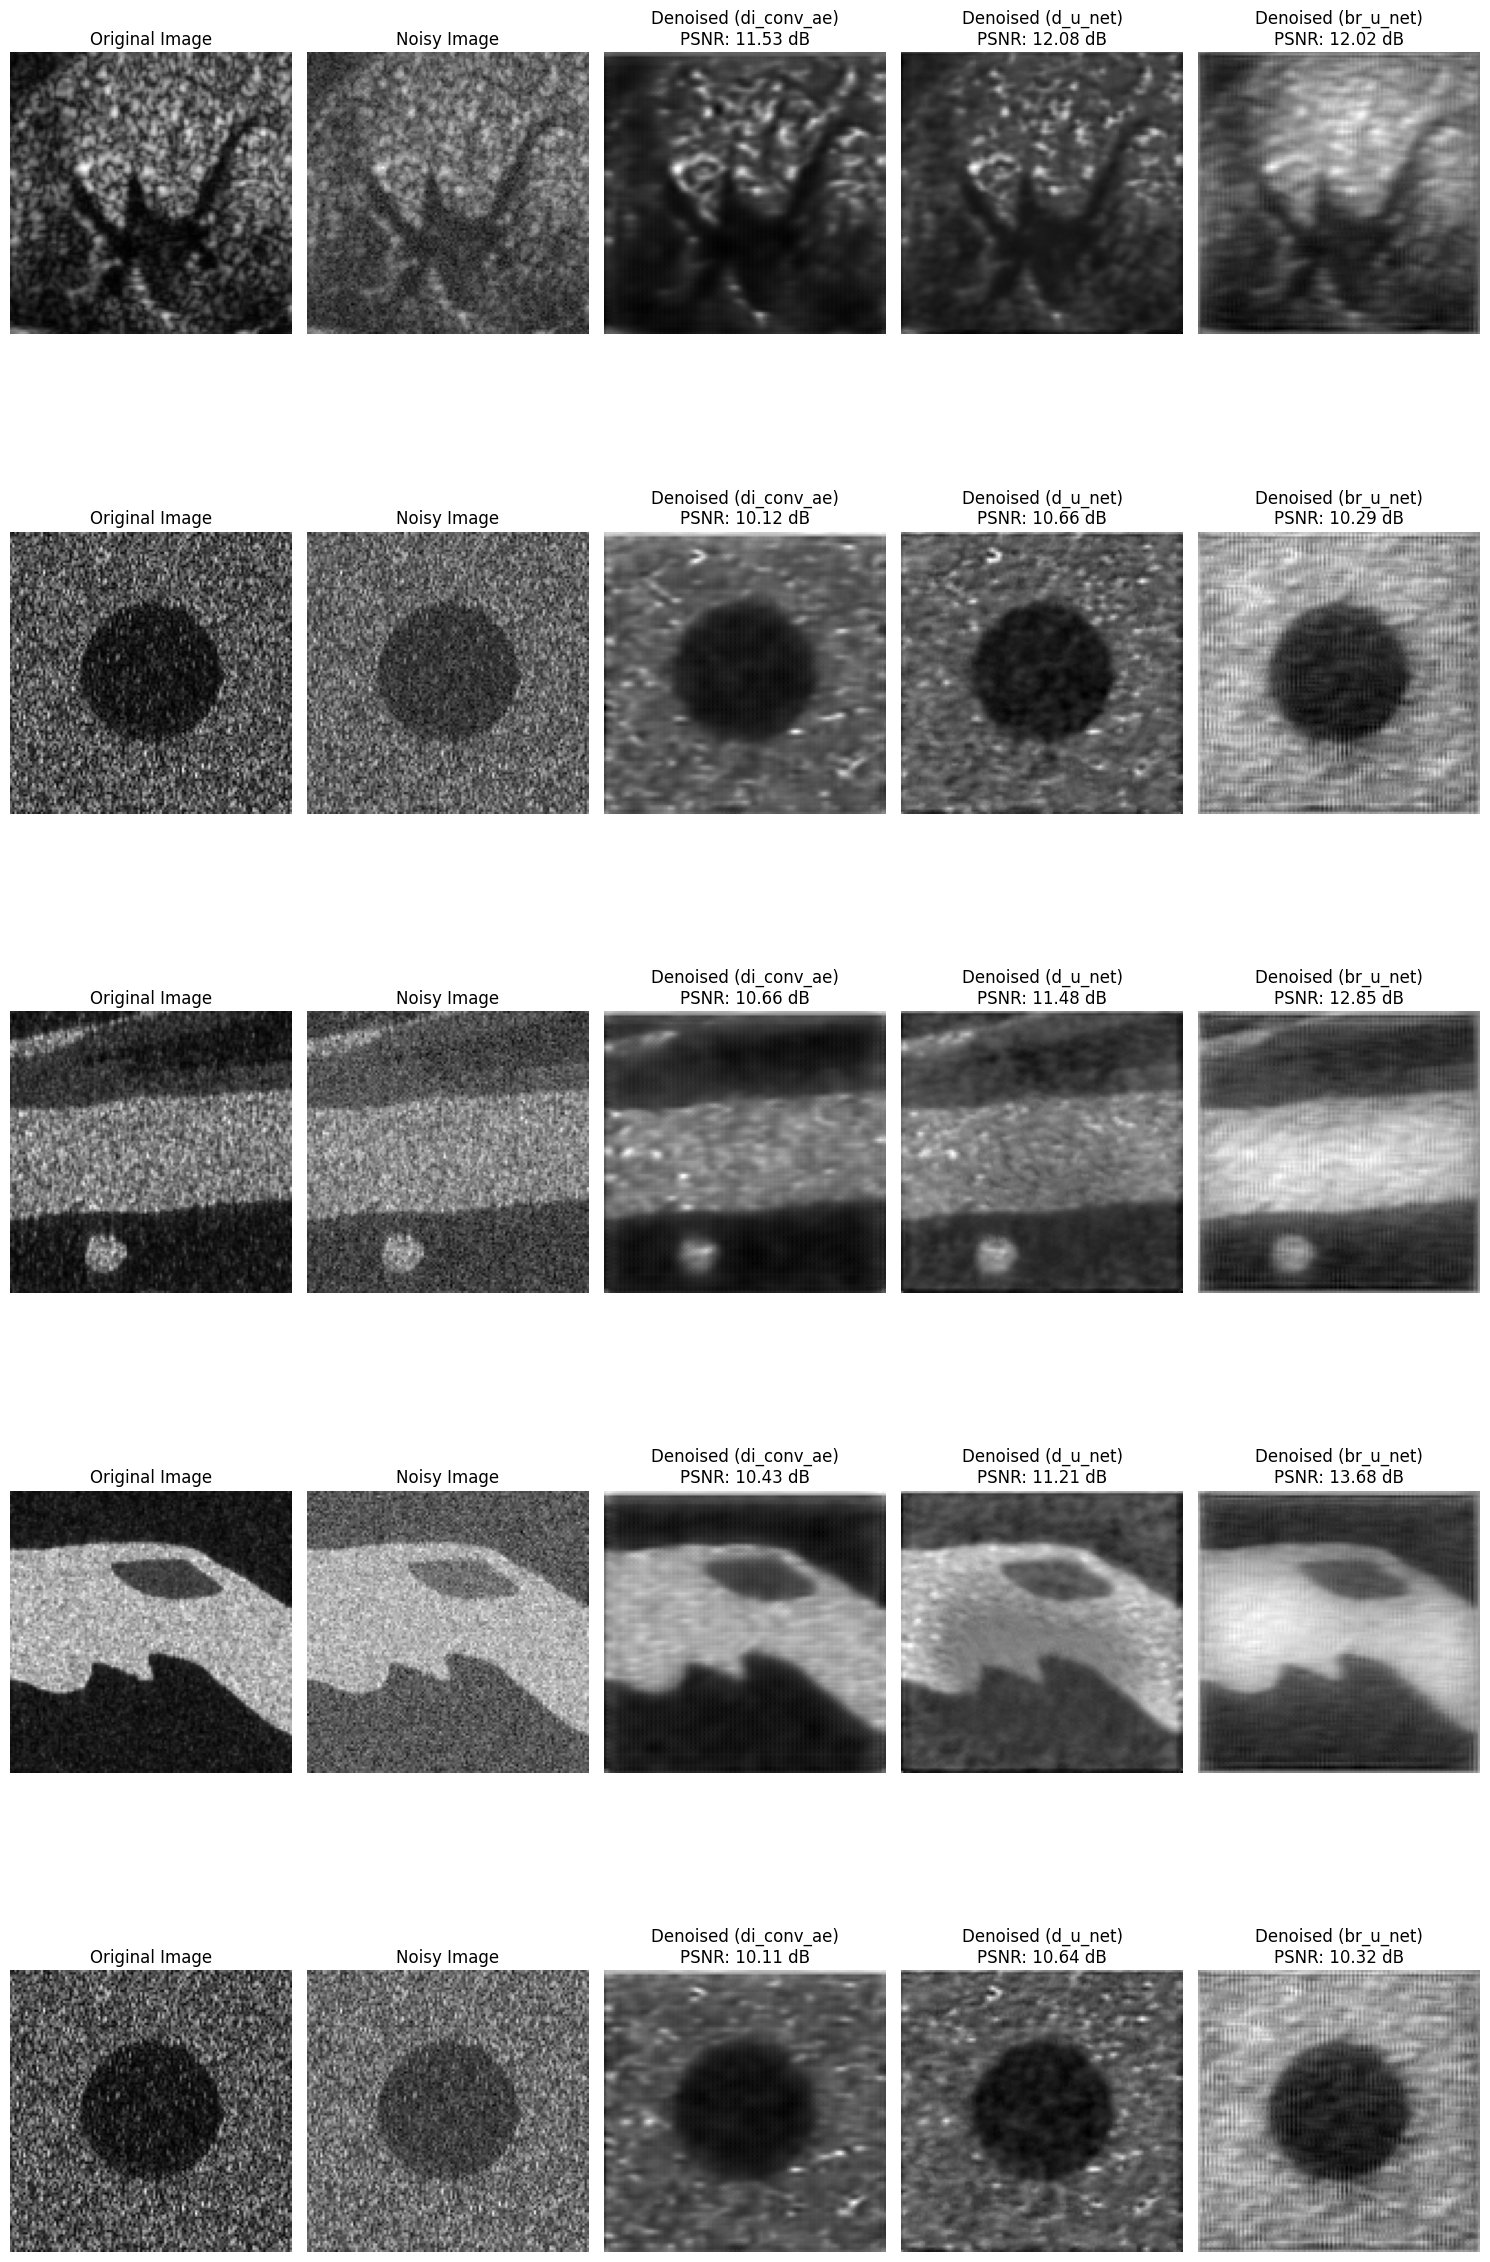

In [2]:

# Model dictionary
model_dict = {
    'di_conv_ae': DilatedConvAutoencoder(),
    'd_u_net': DenoisingUNet(),
    'br_u_net': BatchRenormalizationUNet()
}

# Load the models and their weights
for model_name in model_dict:
    model_dict[model_name].load_state_dict(torch.load(f"model_train/{model_name}_trained_model.pth", map_location=DEVICE))
    model_dict[model_name].to(DEVICE)
    model_dict[model_name].eval()

# Directory containing the test images
test_dir = "Test"

# Preprocessing transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
norm = transforms.Normalize(mean=[0.5], std=[0.5])

# Get test images
test_images = [f for f in os.listdir(test_dir) if f.endswith((".png", ".jpg", ".tif"))]
num_images = len(test_images)

# Set up the figure
fig, axes = plt.subplots(num_images, 2 + len(model_dict), figsize=(15, 5 * num_images))
if num_images == 1:  # Handle the case of a single image
    axes = np.expand_dims(axes, axis=0)

for idx, filename in enumerate(test_images):
    input_path = os.path.join(test_dir, filename)
    original_img = Image.open(input_path).convert("L")

    # Preprocess the original image
    original_tensor = transform(original_img).unsqueeze(0)  # Shape: [1, 1, 128, 128]

    # Add speckle noise
    noisy_tensor = add_speckle_noise(original_tensor.squeeze(0))
    noisy_tensor = norm(noisy_tensor).unsqueeze(0)  # Re-add batch dim for the model

    # Convert tensors to NumPy for visualization
    original_image_np = original_tensor.squeeze().cpu().numpy() * 0.5 + 0.5  # Denormalize for visualization
    noisy_image_np = noisy_tensor.squeeze().cpu().numpy() * 0.5 + 0.5  # Denormalize for visualization

    # Plot original and noisy images
    axes[idx, 0].imshow(original_image_np, cmap="gray")
    axes[idx, 0].set_title("Original Image")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(noisy_image_np, cmap="gray")
    axes[idx, 1].set_title("Noisy Image")
    axes[idx, 1].axis("off")

    # Process the noisy image with each model
    for model_idx, (model_name, model) in enumerate(model_dict.items()):
        with torch.no_grad():
            denoised_tensor = model(noisy_tensor.to(DEVICE))

        # Convert denoised tensor to NumPy
        denoised_image_np = denoised_tensor.squeeze().cpu().numpy() * 0.5 + 0.5  # Denormalize for visualization

        # Calculate PSNR
        psnr_value = psnr(original_tensor.squeeze().cpu(), denoised_tensor.squeeze().cpu())

        # Plot denoised image
        axes[idx, 2 + model_idx].imshow(denoised_image_np, cmap="gray")
        axes[idx, 2 + model_idx].set_title(f"Denoised ({model_name})\nPSNR: {psnr_value:.2f} dB")
        axes[idx, 2 + model_idx].axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_25171/3773397516.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict[model_name].load_state_dict(torch.load(f"{model_name}_trained_model.pth", map

Loading 5 train images...


100%|██████████| 5/5 [00:00<00:00, 124.29it/s]


Loading 5 test images...


100%|██████████| 5/5 [00:00<00:00, 356.37it/s]


Loaded 5 train and 5 test images.


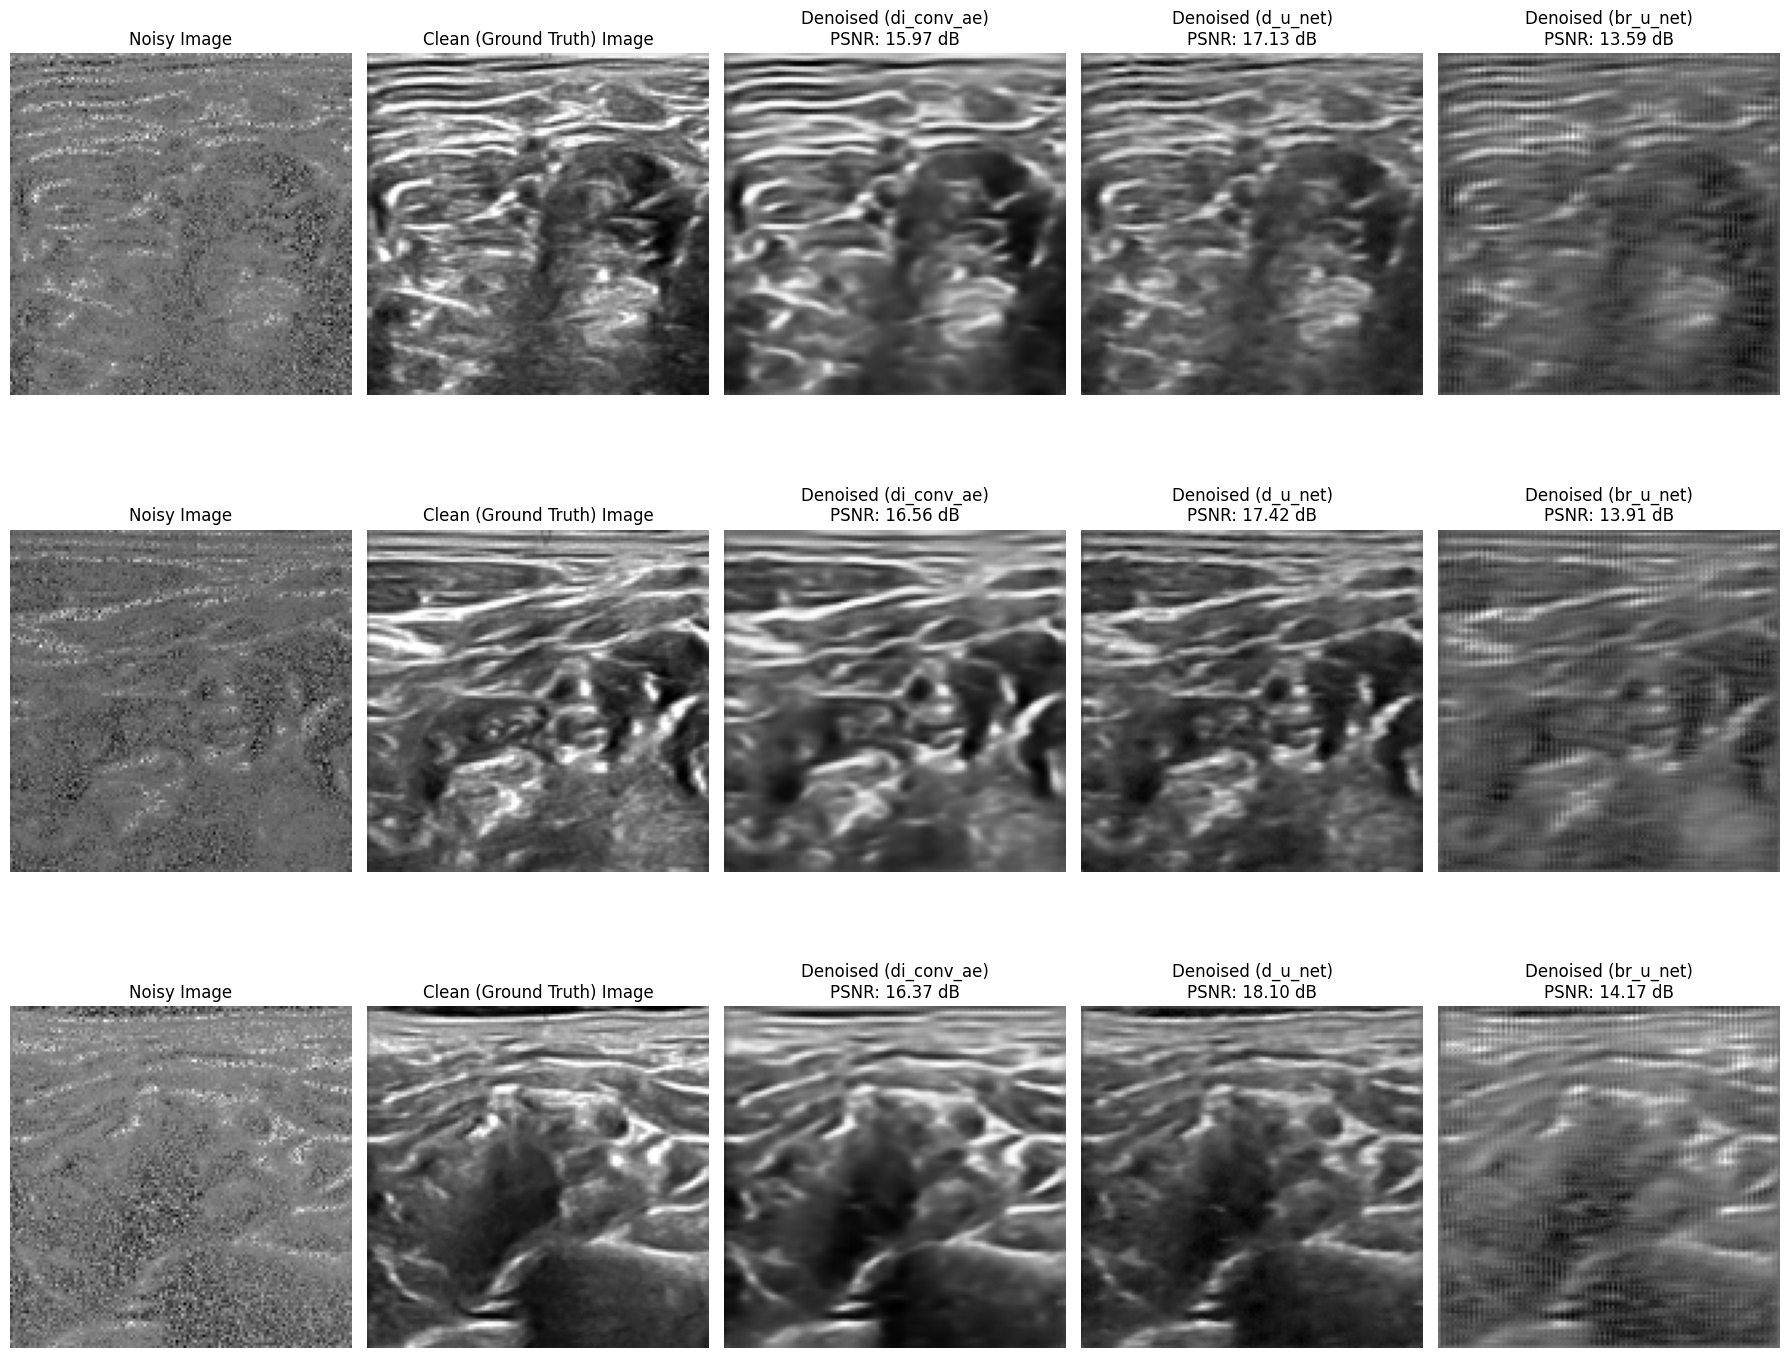

In [3]:
import torch
from dataset.dataset import NoisyDataset, get_images_data
import matplotlib.pyplot as plt
import numpy as np
from models.unets.unets import BatchRenormalizationUNet, DenoisingUNet  # Models
from models.autoencoder import DilatedConvAutoencoder  # Autoencoder
from config import DEVICE
from utils.utils import psnr

# Define model dictionary
model_dict = {
    'di_conv_ae': DilatedConvAutoencoder(),
    'd_u_net': DenoisingUNet(),
    'br_u_net': BatchRenormalizationUNet()
}

# Load the trained models
for model_name in model_dict:
    model_dict[model_name].load_state_dict(torch.load(f"model_train/{model_name}_trained_model.pth", map_location=DEVICE))
    model_dict[model_name].to(DEVICE)
    model_dict[model_name].eval()

# Load the dataset
train_images, test_images = get_images_data(trim=5)  # Adjust trim to limit the number of images
dataset_args = {
    'speckle_mean_add': 0.0,
    'speckle_std_add': 0.1,
    'speckle_mean_mul': 0.0,
    'speckle_std_mul': 0.1,
    'transform': None
}
test_dataset = NoisyDataset(test_images, kwargs=dataset_args)

# Number of images to process
num_images = 3

# Set up the figure for visualization
fig, axes = plt.subplots(num_images, 2 + len(model_dict), figsize=(18, 5 * num_images))
if num_images == 1:
    axes = np.expand_dims(axes, axis=0)  # Handle single-row case

for idx in range(num_images):
    noisy_image, clean_image = test_dataset[idx]
    noisy_image_tensor = noisy_image.unsqueeze(0).to(DEVICE)

    # Convert noisy and clean images to NumPy for visualization
    noisy_image_np = noisy_image.squeeze().cpu().numpy()
    clean_image_np = clean_image.squeeze().cpu().numpy()

    # Plot noisy and clean images
    axes[idx, 0].imshow(noisy_image_np, cmap="gray")
    axes[idx, 0].set_title("Noisy Image")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(clean_image_np, cmap="gray")
    axes[idx, 1].set_title("Clean (Ground Truth) Image")
    axes[idx, 1].axis("off")

    # Denoise using all models
    for model_idx, (model_name, model) in enumerate(model_dict.items()):
        with torch.no_grad():
            denoised_tensor = model(noisy_image_tensor)

        # Convert denoised image to NumPy
        denoised_image_np = denoised_tensor.squeeze().cpu().numpy()

        # Calculate PSNR
        psnr_value = psnr(clean_image, denoised_tensor.squeeze().cpu())

        # Plot denoised image
        axes[idx, 2 + model_idx].imshow(denoised_image_np, cmap="gray")
        axes[idx, 2 + model_idx].set_title(f"Denoised ({model_name})\nPSNR: {psnr_value:.2f} dB")
        axes[idx, 2 + model_idx].axis("off")

plt.tight_layout()
plt.show()
